In [1]:
!date

Tue Dec  1 20:20:41 PST 2020


# No filter Smart-seq2 isoform comparison to 10x

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [3]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

# Perform comparison

In [4]:
ss = anndata.read_h5ad("../../data/notebook/revision/no_filter_smartseq_isoform.h5ad")

md = pd.read_csv("../../reference/smart-seq_cluster_labels/sample_metadata.csv", index_col = 0)
ss.obs["sex"] = ss.obs.cell_id.map(md["gender"])

In [5]:
ss

AnnData object with n_obs × n_vars = 6295 × 111079
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'sex'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'log1p', 'norm', 'raw', 'scaled'

In [6]:
ss.var = ss.var.set_index("transcript_name")
ss = ss[:, ss.var.sort_index().index]

In [7]:
ss.obs.sex.value_counts()

M    4333
F    1962
Name: sex, dtype: int64

In [8]:
md = pd.read_csv("../../reference/10xv3_cluster_labels/sample_metadata.csv", index_col = 0)

md["sex"] = md["Gender"].apply(lambda x: {"Male": "M", "Female":"F"}.get(x, "X"))

tenx = anndata.read_h5ad("../../data/notebook/revision/10xv3_isoform_processed.h5ad")
tenx.obs["date"] = tenx.obs.index.map(md["Amp_Date"])
tenx.obs["sex"] =  tenx.obs.index.map(md["sex"])

tenx = tenx[:,tenx.var.transcript_name.isin(ss.var.index)]

tenx.var.index = tenx.var.transcript_name.values
#tenx = tenx[tenx.obs.eval("date == '11/29/2018'").values] # males
#tenx = tenx[tenx.obs.eval("date == '12/7/2018'").values] # females
tenx = tenx[tenx.obs.eval("date == '4/26/2019'").values] # females and males

tenx = tenx[:,tenx.var.sort_index().index]

In [9]:
tenx.obs.sex.value_counts()

M    19049
F    16321
Name: sex, dtype: int64

In [10]:
print(tenx)
print(ss)

View of AnnData object with n_obs × n_vars = 35370 × 111079
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'date', 'sex'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov', 'transcript_name'
    layers: 'X', 'log1p', 'norm'
View of AnnData object with n_obs × n_vars = 6295 × 111079
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'sex'
    var: 'transcript_id', 'gene_id', 'gene_name', 'length'
    layers: 'log1p', 'norm', 'raw', 'scaled'


In [11]:
(tenx.var.index.values !=  ss.var.index.values).sum() == 0

True

In [12]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

In [19]:
%%time
mat = tenx.layers["log1p"].todense()

CPU times: user 7.31 s, sys: 16.5 s, total: 23.8 s
Wall time: 23.8 s


In [21]:
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)

In [24]:
mtx.shape

(35370, 111079)

In [14]:
del mat
del mtx

In [15]:
%%time
mat = ss.layers["log1p"]
ssmtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
ss.X = ssmtx

CPU times: user 6min 27s, sys: 41.9 s, total: 7min 9s
Wall time: 7min 9s


In [16]:
del mat
del mtx

In [27]:
tenx_mat = mtx
tenx_ass = tenx.obs.subclass_label.values

ss_mat = ss.X.todense()
ss_ass = ss.obs.subclass_label.values

In [28]:
features = tenx.var.transcript_name.values

unique = np.intersect1d(np.unique(tenx_ass), np.unique(ss_ass))

In [30]:
%%time
mat = tenx.layers["log1p"]

lower = 0.5


bool_mask = np.zeros((unique.shape[0], features.shape[0]), dtype=bool)

for uidx, u in enumerate(unique):
    t_mat, _ = split_by_target(mat, tenx_ass, u)

    numc = t_mat.shape[0]
    numnz = (t_mat>0).sum(axis=0)

    #arr = np.logical_and(nd(numnz>lower*numc), nd(numnz<upper*numc))
    arr = nd(numnz>lower*numc)
    
    #arr = np.logical_and(np.array(t_mat.mean(axis=0)>threshold).reshape(-1), (np.array((t_mat>0).sum(axis=0)>t_mat.shape[0]*frac).reshape(-1)))
    print("[{} of {}] {:,}: {}".format(uidx+1, unique.shape[0],arr.sum(), u) )
    
    #argnmax = arr.argsort()[-n:][::-1]

    bool_mask[uidx,:][arr] = True

[1 of 18] 311: Astro
[2 of 18] 446: Endo
[3 of 18] 4,033: L2/3 IT
[4 of 18] 3,447: L5 IT
[5 of 18] 2,689: L5 PT
[6 of 18] 2,839: L5/6 NP
[7 of 18] 3,421: L6 CT
[8 of 18] 3,926: L6 IT
[9 of 18] 3,645: L6 IT Car3
[10 of 18] 3,797: L6b
[11 of 18] 3,042: Lamp5
[12 of 18] 555: Low Quality
[13 of 18] 3,449: Pvalb
[14 of 18] 987: SMC
[15 of 18] 3,505: Sncg
[16 of 18] 3,517: Sst
[17 of 18] 244: VLMC
[18 of 18] 1,914: Vip
CPU times: user 6.35 s, sys: 9.1 s, total: 15.4 s
Wall time: 15.4 s


In [31]:
%%time
rvals = []
ss_x = []
tenx_x = []

# u_mat_tenx = []
# u_mat_ss   = []

for uidx, u in enumerate(unique):
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    # u_mat_tenx.append(tenx_t_mat)
    # u_mat_ss.append(ss_t_mat)
    
    
    t = np.asarray(tenx_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    tenx_x.append(t)
    
    r, p = stats.pearsonr(t, s)
    rvals.append(r)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r, u) )

[1 of 18] 0.84: Astro
[2 of 18] 0.89: Endo
[3 of 18] 0.69: L2/3 IT
[4 of 18] 0.59: L5 IT
[5 of 18] 0.60: L5 PT
[6 of 18] 0.82: L5/6 NP
[7 of 18] 0.72: L6 CT
[8 of 18] 0.72: L6 IT
[9 of 18] 0.71: L6 IT Car3
[10 of 18] 0.78: L6b
[11 of 18] 0.87: Lamp5
[12 of 18] -0.51: Low Quality
[13 of 18] 0.86: Pvalb
[14 of 18] 0.63: SMC
[15 of 18] 0.87: Sncg
[16 of 18] 0.87: Sst
[17 of 18] 0.59: VLMC
[18 of 18] 0.83: Vip
CPU times: user 1min 11s, sys: 3min 28s, total: 4min 39s
Wall time: 4min 39s


In [32]:
ss_size = ss.obs["subclass_label"].value_counts()[unique]

In [33]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

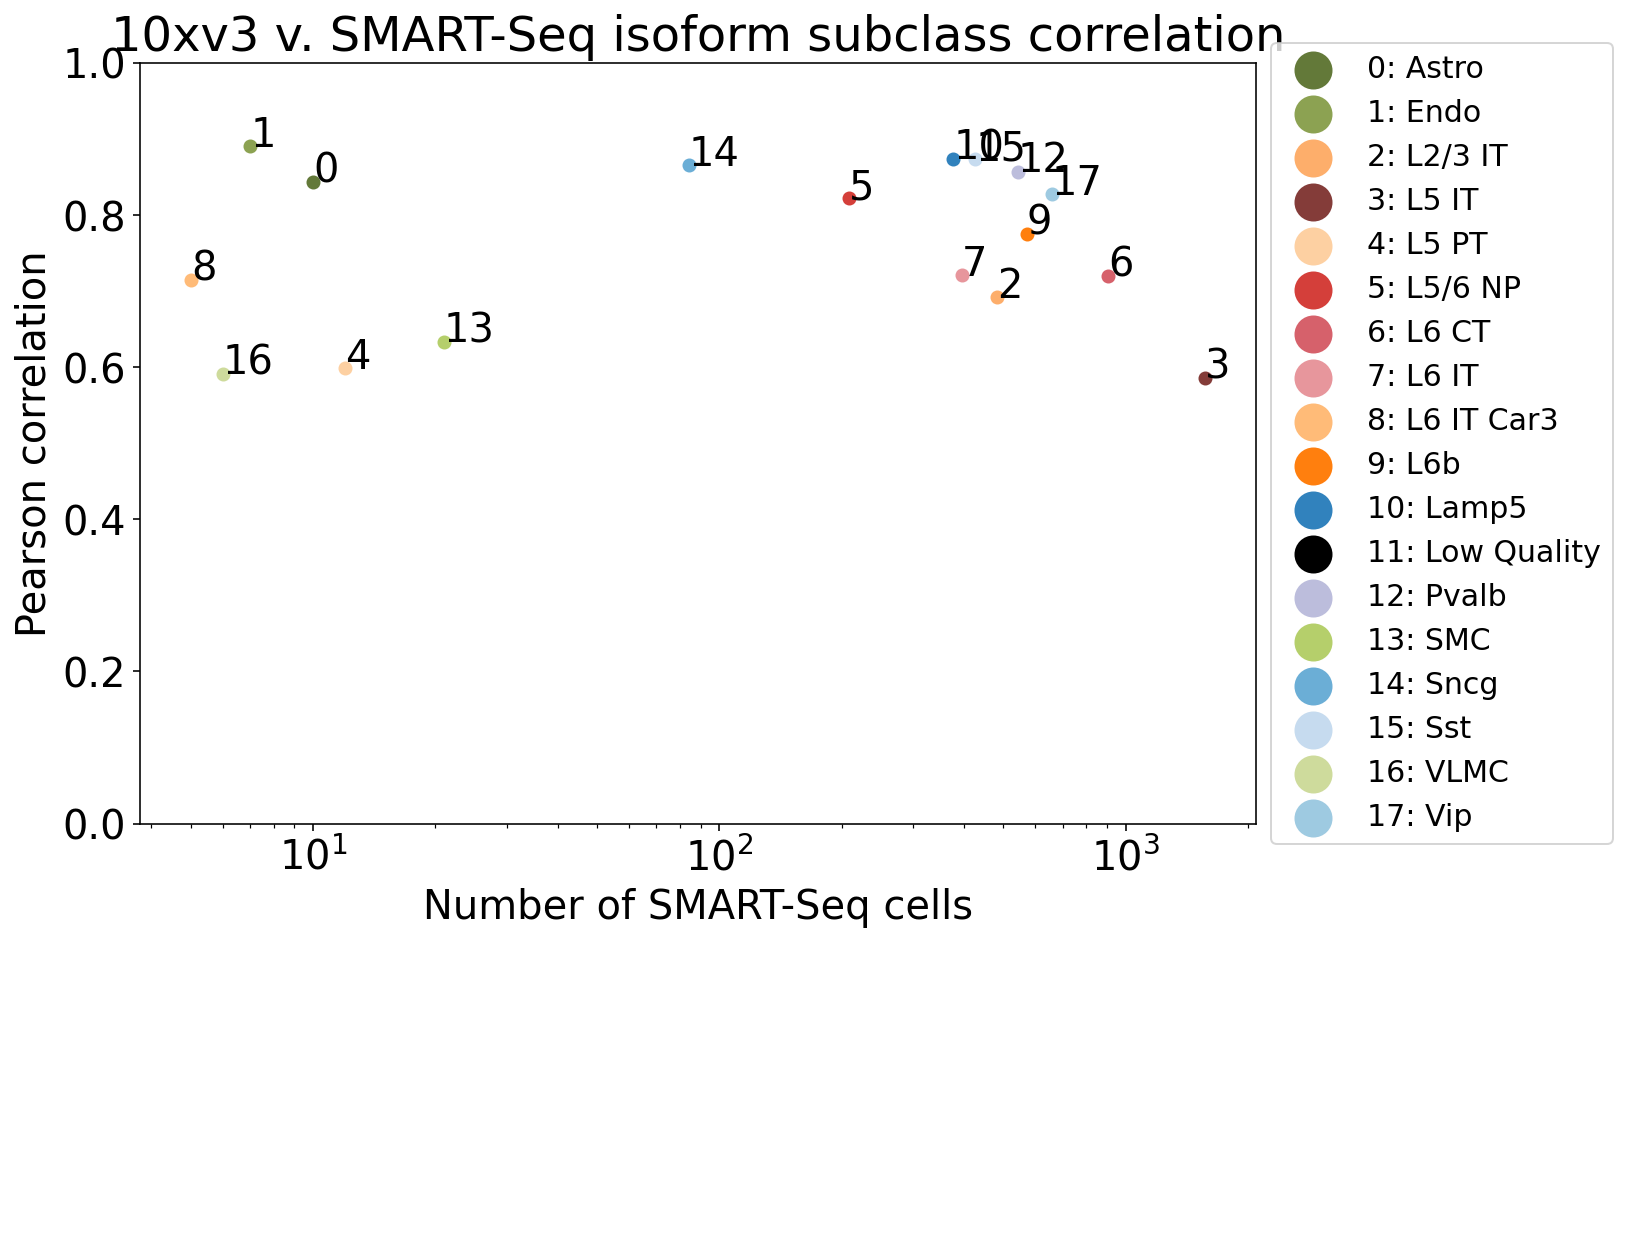

In [36]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = rvals

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of SMART-Seq cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
ax.set_title("10xv3 v. SMART-Seq isoform subclass correlation")

plt.savefig(trackfig("../../figures/10x_smartseq_isoform_subclass_correlation_size.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)
plt.show()

In [37]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

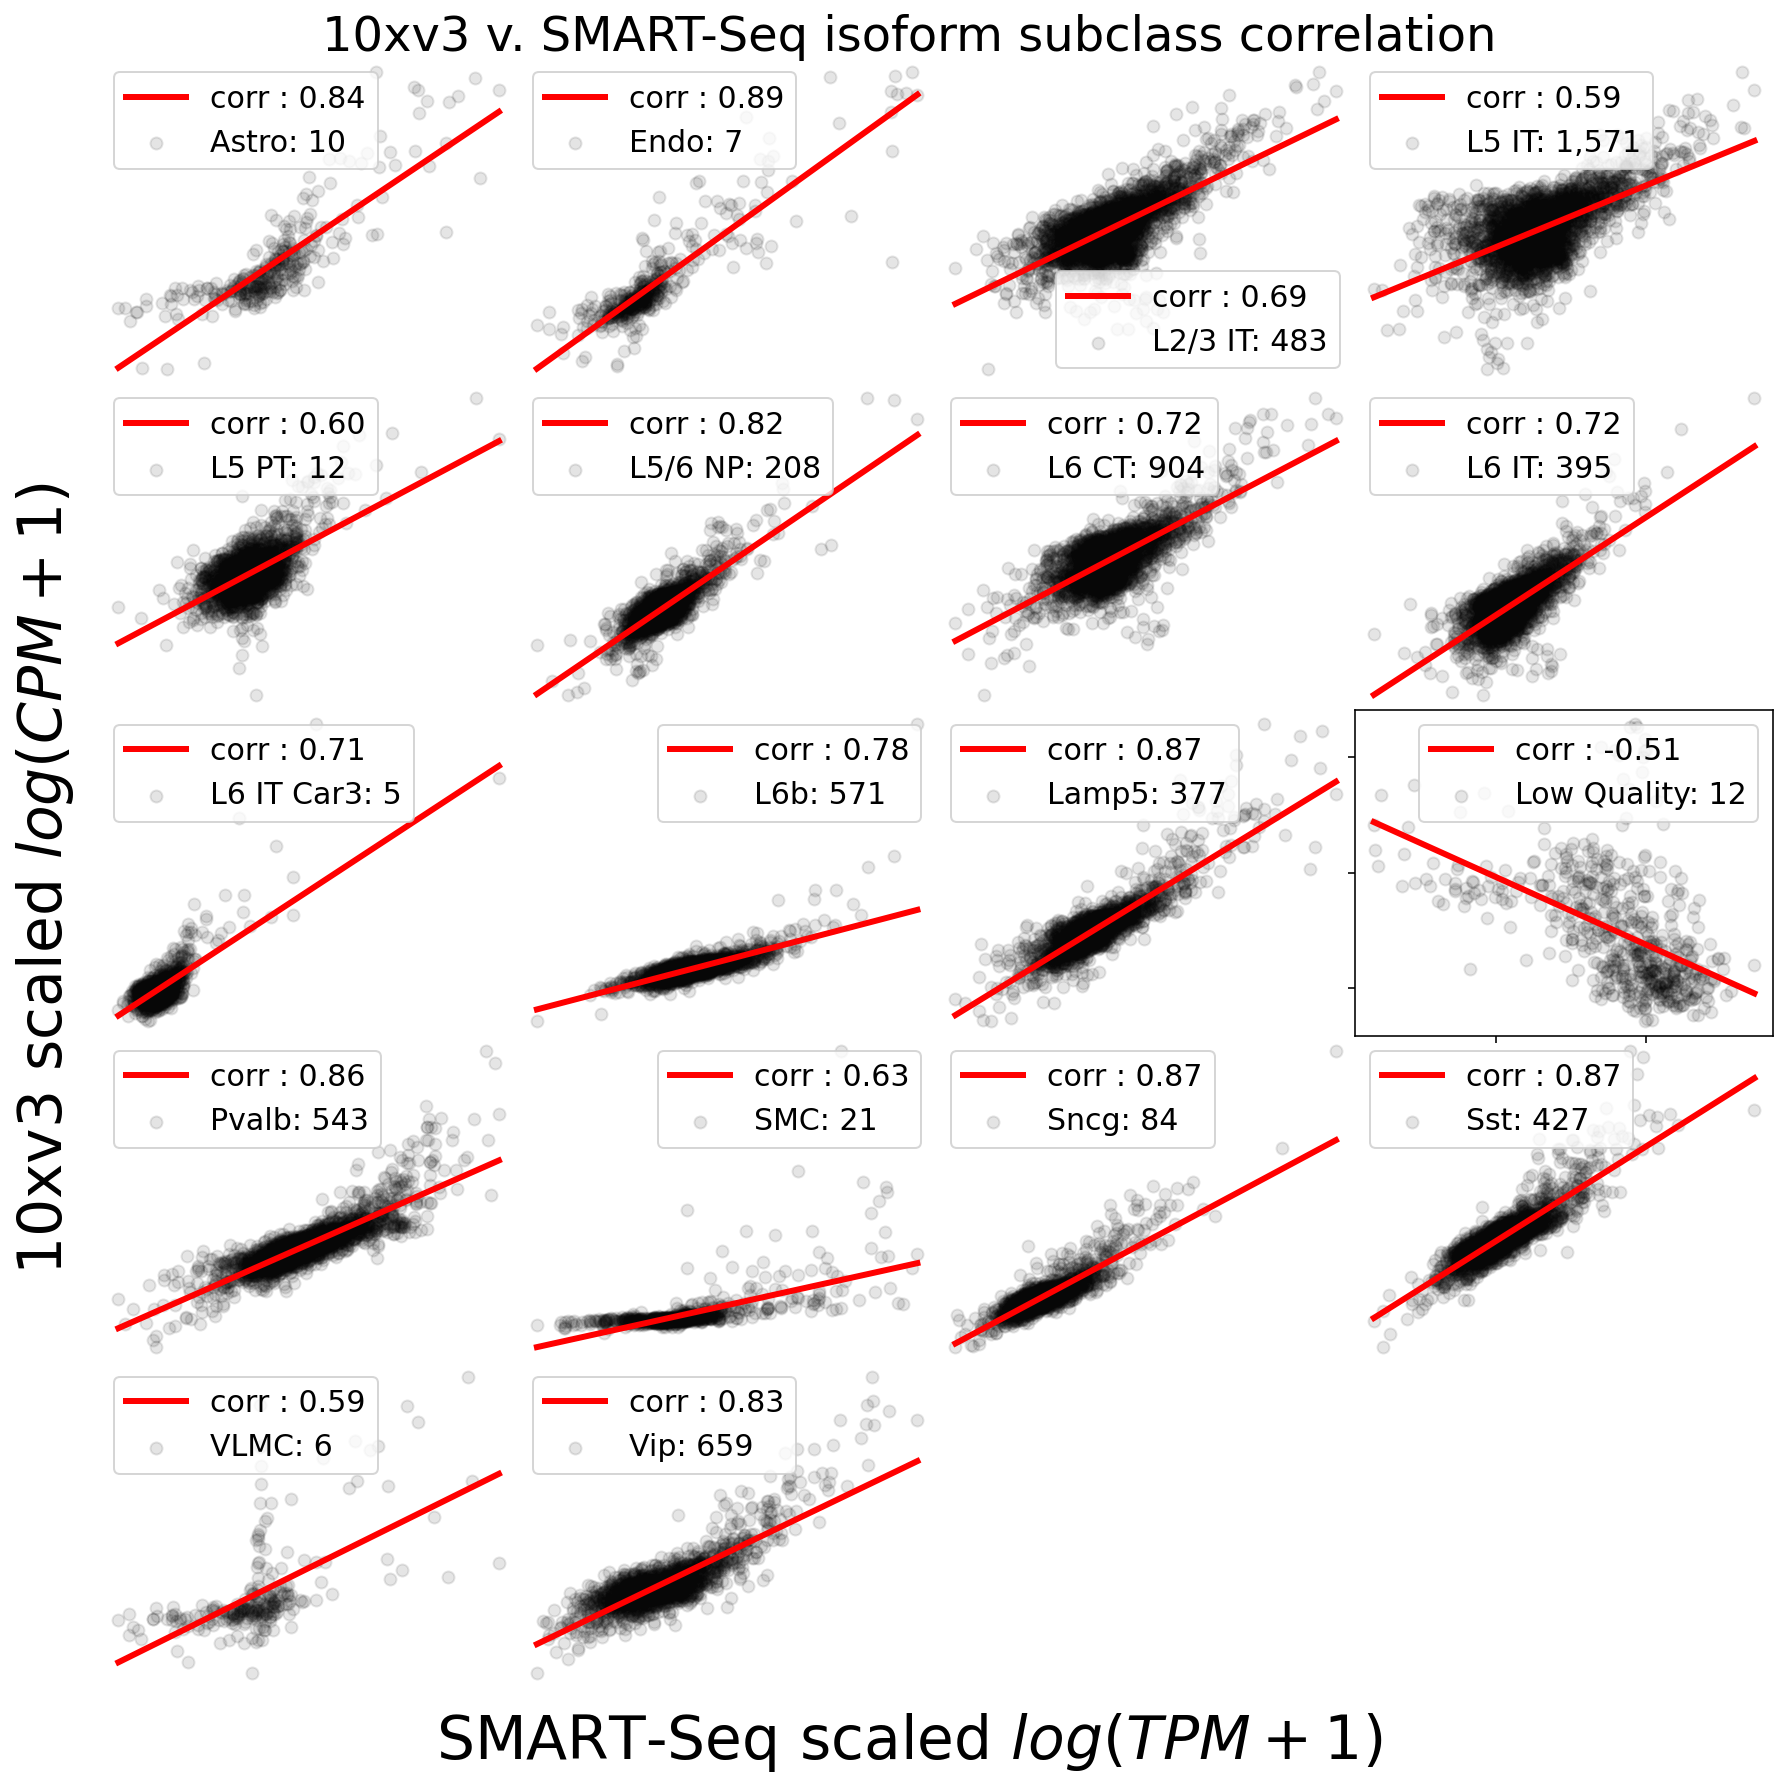

In [39]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))
fig.suptitle('10xv3 v. SMART-Seq isoform subclass correlation', y=0.9)

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = tenx_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="corr : {:,.2f}".format(r_value), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
    if c == "Low Quality":
        ax.set_axis_on()
fig.text(0.5, 0.1, 'SMART-Seq scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig(trackfig("../../figures/10x_smartseq_isoform_subclass_correlation_scatter.png", TRACKFIG, NB), bbox_inches='tight',dpi=300)

plt.show()

# At the cluster level

In [40]:
tenx_ass = tenx.obs.cluster_label.values
ss_ass = ss.obs.cluster_label.values

In [41]:
features = tenx.var.transcript_name.values

unique = np.intersect1d(np.unique(tenx_ass), np.unique(ss_ass))

In [42]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [43]:
mat = tenx.layers["log1p"]

lower = 0.5


bool_mask = np.zeros((unique.shape[0], features.shape[0]), dtype=bool)

for uidx, u in enumerate(unique):
    t_mat, _ = split_by_target(mat, tenx_ass, u)

    numc = t_mat.shape[0]
    numnz = (t_mat>0).sum(axis=0)

    #arr = np.logical_and(nd(numnz>lower*numc), nd(numnz<upper*numc))
    arr = nd(numnz>lower*numc)
    
    #arr = np.logical_and(np.array(t_mat.mean(axis=0)>threshold).reshape(-1), (np.array((t_mat>0).sum(axis=0)>t_mat.shape[0]*frac).reshape(-1)))
    print("[{} of {}] {:,}: {}".format(uidx+1, unique.shape[0],arr.sum(), u) )
    
    #argnmax = arr.argsort()[-n:][::-1]

    bool_mask[uidx,:][arr] = True

[1 of 22] 311: Astro Aqp4
[2 of 22] 3,864: L5 IT Pld5
[3 of 22] 3,872: L5 IT Tcap_1
[4 of 22] 3,022: L5 IT Tcap_2
[5 of 22] 3,049: L6 CT Gpr139
[6 of 22] 3,645: L6 IT Car3
[7 of 22] 4,162: L6b Rprm
[8 of 22] 3,127: L6b Shisa6
[9 of 22] 3,062: Lamp5 Lhx6
[10 of 22] 3,917: Pvalb Calb1
[11 of 22] 3,343: Pvalb Reln
[12 of 22] 3,262: Pvalb Vipr2
[13 of 22] 3,538: Sst Chodl
[14 of 22] 4,243: Sst Crhr2_1
[15 of 22] 4,182: Sst Crhr2_2
[16 of 22] 2,901: Sst Myh8_1
[17 of 22] 3,228: Sst Myh8_2
[18 of 22] 2,078: Vip C1ql1
[19 of 22] 1,849: Vip Crispld2
[20 of 22] 2,462: Vip Gpc3
[21 of 22] 1,574: Vip Igfbp6
[22 of 22] 2,418: Vip Serpinf1


In [44]:
%%time
rvals = []
ss_x = []
tenx_x = []

# u_mat_tenx = []
# u_mat_ss   = []

for uidx, u in enumerate(unique):
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    # u_mat_tenx.append(tenx_t_mat)
    # u_mat_ss.append(ss_t_mat)
    
    
    t = np.asarray(tenx_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    tenx_x.append(t)
    
    r, p = stats.pearsonr(t, s)
    rvals.append(r)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r, u) )

[1 of 22] 0.84: Astro Aqp4
[2 of 22] 0.35: L5 IT Pld5
[3 of 22] 0.54: L5 IT Tcap_1
[4 of 22] 0.46: L5 IT Tcap_2
[5 of 22] 0.75: L6 CT Gpr139
[6 of 22] 0.71: L6 IT Car3
[7 of 22] 0.67: L6b Rprm
[8 of 22] 0.65: L6b Shisa6
[9 of 22] 0.69: Lamp5 Lhx6
[10 of 22] 0.83: Pvalb Calb1
[11 of 22] 0.85: Pvalb Reln
[12 of 22] 0.78: Pvalb Vipr2
[13 of 22] 0.87: Sst Chodl
[14 of 22] 0.75: Sst Crhr2_1
[15 of 22] 0.74: Sst Crhr2_2
[16 of 22] 0.85: Sst Myh8_1
[17 of 22] 0.81: Sst Myh8_2
[18 of 22] 0.80: Vip C1ql1
[19 of 22] 0.85: Vip Crispld2
[20 of 22] 0.81: Vip Gpc3
[21 of 22] 0.79: Vip Igfbp6
[22 of 22] 0.62: Vip Serpinf1
CPU times: user 1min 26s, sys: 2min 49s, total: 4min 15s
Wall time: 4min 14s


In [45]:
ss_size = ss.obs["cluster_label"].value_counts()[unique]

In [46]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [47]:
unique

array(['Astro Aqp4', 'L5 IT Pld5', 'L5 IT Tcap_1', 'L5 IT Tcap_2',
       'L6 CT Gpr139', 'L6 IT Car3', 'L6b Rprm', 'L6b Shisa6',
       'Lamp5 Lhx6', 'Pvalb Calb1', 'Pvalb Reln', 'Pvalb Vipr2',
       'Sst Chodl', 'Sst Crhr2_1', 'Sst Crhr2_2', 'Sst Myh8_1',
       'Sst Myh8_2', 'Vip C1ql1', 'Vip Crispld2', 'Vip Gpc3',
       'Vip Igfbp6', 'Vip Serpinf1'], dtype=object)

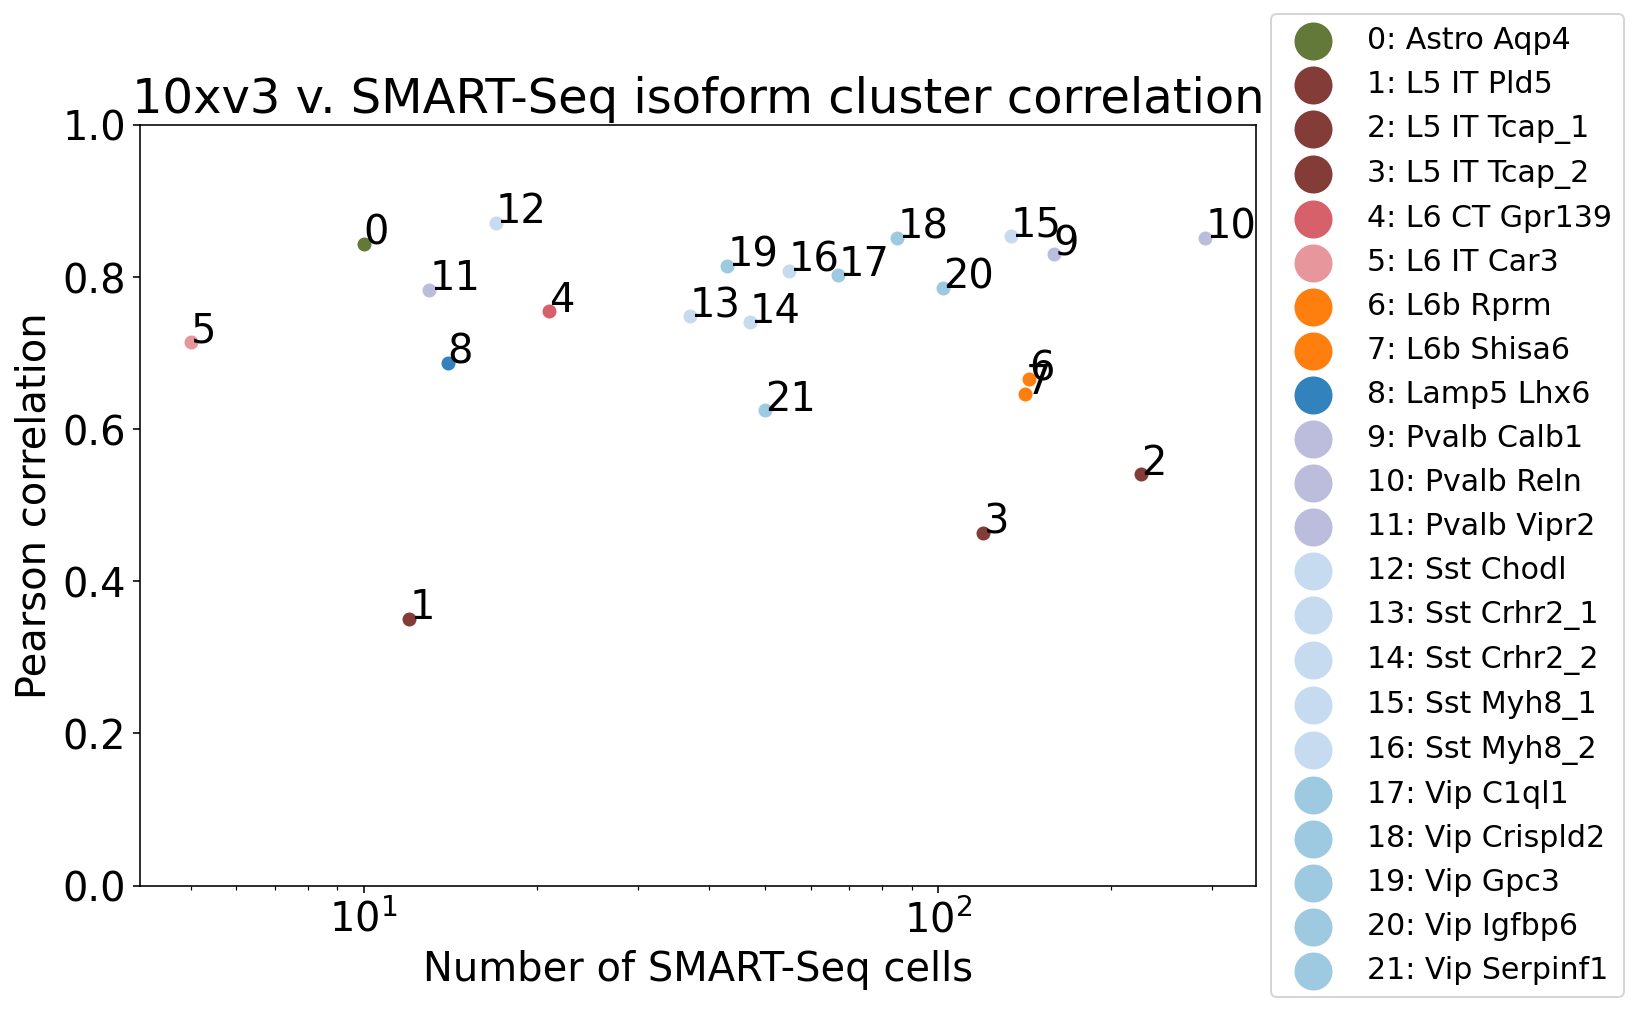

In [51]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = rvals

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[" ".join(txt.split(" ")[0:-1])])
ax.set_ylim((0, 1))
ax.set_xscale("log")
ax.set_title("10xv3 v. SMART-Seq isoform cluster correlation")

ax.set_xlabel("Number of SMART-Seq cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
plt.savefig(trackfig("../../figures/10x_smartseq_isoform_cluster_correlation.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)
plt.show()

In [50]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

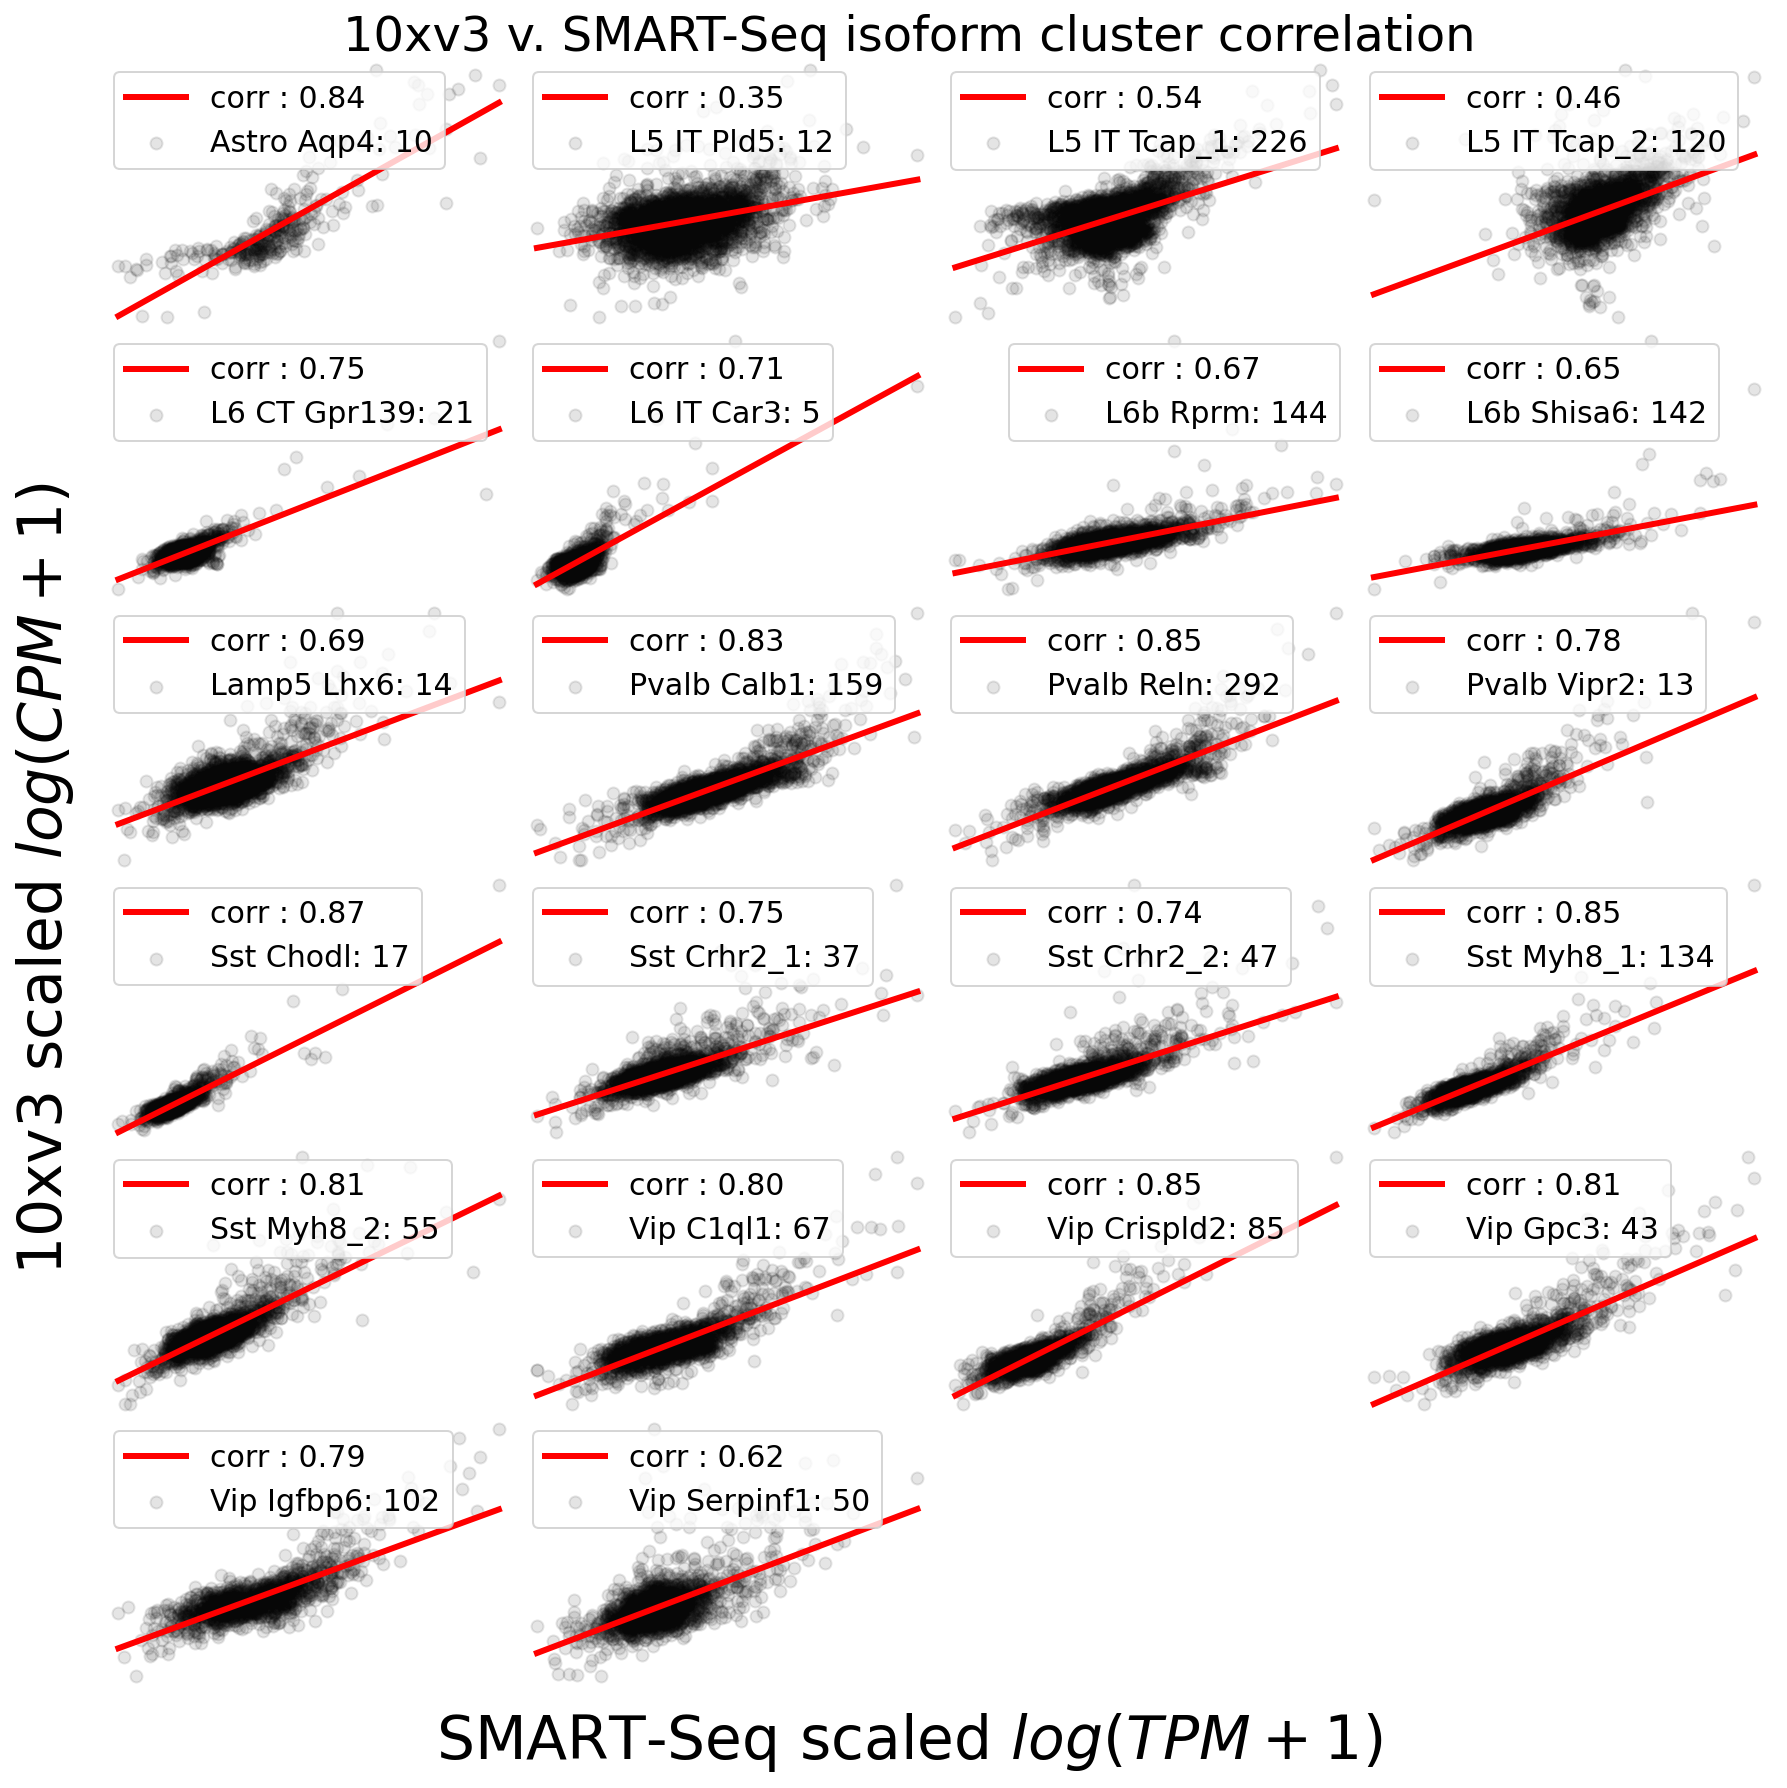

In [52]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=6)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))

fig.suptitle('10xv3 v. SMART-Seq isoform cluster correlation', y=0.9)


for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = tenx_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="corr : {:,.2f}".format(r_value), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
    if c == "Low Quality":
        ax.set_axis_on()
fig.text(0.5, 0.1, 'SMART-Seq scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig(trackfig("../../figures/10x_smartseq_isoform_cluster_correlation_scatter.png", TRACKFIG, NB), bbox_inches='tight',dpi=300)

plt.show()
